IMPORTING MODULES

In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import os

IMPORTING DATASET

In [12]:
train_df = pd.read_csv('/Users/alex/Desktop/projects/OCR/dataset/emnist-balanced-train.csv',header=None)
test_df = pd.read_csv('/Users/alex/Desktop/projects/OCR/dataset/emnist-balanced-test.csv', header=None)

In [13]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,45,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,43,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


PREPROCESS DATA

In [14]:
#Defining train and test data
x_train = train_df.drop(0, axis=1)
y_train = train_df[0]
x_test = test_df.drop(0, axis=1)
y_test = test_df[0]

In [15]:
#Reshaping data
x_train = np.array(x_train).reshape((-1, 28, 28))
x_test = np.array(x_test).reshape((-1, 28, 28))
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((112800, 28, 28), (18800, 28, 28), (112800,), (18800,))

In [9]:
#transforming 1 channel to RGB
'''
x_train_expanded = tf.expand_dims(x_train, axis=-1)
x_train_rgb = tf.repeat(x_train_expanded, 3, axis=-1)
x_test_expanded = tf.expand_dims(x_test, axis=-1)
x_test_rgb = tf.repeat(x_test_expanded, 3, axis=-1)
'''

TensorShape([112800, 28, 28, 3])

In [16]:
y_train.sort_index().value_counts()

0
45    2400
7     2400
22    2400
34    2400
9     2400
30    2400
38    2400
39    2400
37    2400
31    2400
16    2400
2     2400
28    2400
8     2400
10    2400
6     2400
27    2400
33    2400
11    2400
18    2400
41    2400
0     2400
23    2400
35    2400
36    2400
13    2400
43    2400
15    2400
4     2400
42    2400
26    2400
32    2400
20    2400
1     2400
46    2400
24    2400
25    2400
12    2400
5     2400
17    2400
3     2400
40    2400
14    2400
44    2400
19    2400
29    2400
21    2400
Name: count, dtype: int64

MODEL CREATION

In [22]:
#importing transfer layer from keras
'''
transfer = tf.keras.applications.InceptionV3(input_shape=(75, 75, 3), weights='imagenet', include_top=False)
transfer.trainable = False
'''

In [22]:
METRICS = ['accuracy']
NUM_CLASSES = len(y_train.unique())

def create_model(METRICS, NUM_CLASSES, LEARNING_RATE=1e-3):
    #model creation function
    model = tf.keras.models.Sequential([
        #tf.keras.layers.Resizing(75, 75),
        tf.keras.layers.Rescaling(1./255),
        #transfer,
        tf.keras.layers.Conv2D(64, (3, 3)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
    ])
    model.build(input_shape=(None, 28, 28, 1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='sparse_categorical_crossentropy',
              metrics=METRICS)
    return model

model = create_model(METRICS=METRICS, NUM_CLASSES=NUM_CLASSES)

MODEL TRAINING

In [23]:
#callbacks
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=0.0001)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

In [24]:
EPOCHS = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
CALLBACKS = [model_checkpoint_callback, reduce_lr_callback, early_stopping_callback]

def train_model(x_train, y_train, epochs, validation_split, batch_size, callbacks):
    hist = model.fit(x = x_train, y = y_train, epochs=epochs, validation_split=validation_split, batch_size=batch_size, callbacks=callbacks)
    return hist

history = train_model(x_train, y_train, EPOCHS, VALIDATION_SPLIT, BATCH_SIZE, CALLBACKS)


Epoch 1/100
705/705 [==============================] - ETA: 0s - loss: 1.2216 - accuracy: 0.6388
Epoch 1: val_loss improved from inf to 0.54412, saving model to model.h5
705/705 [==============================] - 46s 64ms/step - loss: 1.2216 - accuracy: 0.6388 - val_loss: 0.5441 - val_accuracy: 0.8202 - lr: 0.0010
Epoch 2/100
  2/705 [..............................] - ETA: 42s - loss: 0.7172 - accuracy: 0.7461

/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


705/705 [==============================] - ETA: 0s - loss: 0.6749 - accuracy: 0.7823
Epoch 2: val_loss improved from 0.54412 to 0.43039, saving model to model.h5
705/705 [==============================] - 47s 66ms/step - loss: 0.6749 - accuracy: 0.7823 - val_loss: 0.4304 - val_accuracy: 0.8477 - lr: 0.0010
Epoch 3/100
705/705 [==============================] - ETA: 0s - loss: 0.5741 - accuracy: 0.8109
Epoch 3: val_loss improved from 0.43039 to 0.41626, saving model to model.h5
705/705 [==============================] - 49s 69ms/step - loss: 0.5741 - accuracy: 0.8109 - val_loss: 0.4163 - val_accuracy: 0.8576 - lr: 0.0010
Epoch 4/100
705/705 [==============================] - ETA: 0s - loss: 0.5156 - accuracy: 0.8282
Epoch 4: val_loss improved from 0.41626 to 0.39538, saving model to model.h5
705/705 [==============================] - 50s 71ms/step - loss: 0.5156 - accuracy: 0.8282 - val_loss: 0.3954 - val_accuracy: 0.8622 - lr: 0.0010
Epoch 5/100
705/705 [==============================]

MODEL EVALUATION

In [25]:
model.evaluate(x_test, y_test)

588/588 [==============================] - 4s 7ms/step - loss: 0.3484 - accuracy: 0.8831


[0.3484213650226593, 0.8831382989883423]

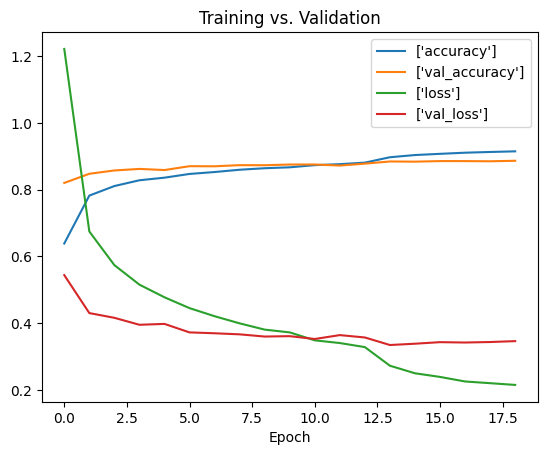

In [27]:
METRICS = ['accuracy', 'loss']
def plot_metrics(hist, metrics):
    for m in metrics:
        plt.title(f'Training vs. Validation')
        plt.xlabel('Epoch')
        plt.plot(hist.epoch, hist.history[m], label=[m])
        plt.plot(hist.epoch, hist.history[f'val_{m}'], label=[f'val_{m}'])
        plt.legend()

plot_metrics(history, METRICS)

In [77]:
recoded = {0  : '0',1  : '1',2  : '2',3  :  '3',4  :  '4',5  :  '5',6  :  '6',7  :  '7',
8  :  '8',9  :  '9',10 :  'A',11 :  'B',12 :  'C',13 :  'D',14 :  'E',15 :  'F',16 :  'G',
17 :  'H',18 :  'I',19 :  'J',20 :  'K',21 :  'L',22 :  'M',23 :  'N',24 :  'O',25 :  'P',
26 :  'Q',27 :  'R',28 :  'S',29 :  'T',30 :  'U',31 :  'V',32 :  'W',33 :  'X',34 :  'Y',
35 :  'Z',36 :  'a',37 :  'b',38 :  'd',39 :  'e',40 :  'f',41 :  'g',42 :  'h',43 :  'n',
44 :  'q',45 :  'r',46 :  't'}

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 11ms/step


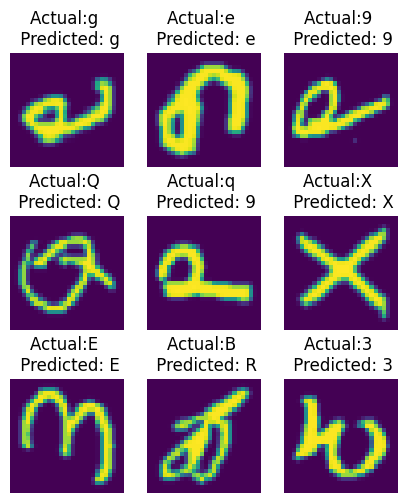

In [84]:
plt.figure(figsize=(5, 6))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(x_test[i])
    plt.axis('off')
    actual_class = y_test[i]
    actual_class = recoded[actual_class]
    for_prediction = tf.expand_dims(x_test[i], axis=-1)
    for_prediction = tf.expand_dims(for_prediction, axis=0)
    predicted_class = model.predict(for_prediction)
    predicted_class = np.argmax(predicted_class)
    predicted_class = recoded[predicted_class]
    plt.title(f'Actual:{actual_class} \n Predicted: {predicted_class}')

SAVE MODEL

In [28]:
def save_model(filepath, model):
    def find_index(filepath):
        index = 0
        while os.path.exists(os.path.join(filepath,f'model_{index}.keras')):
            index += 1
        return index
    last_index = find_index(filepath)
    savepath = os.path.join(filepath, f'model_{last_index}.keras')
    result = model.save(savepath)
    return result
filepath = '/Users/alex/Desktop/projects/OCR/models'
save_model(filepath, model)